In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Начальная симплекс-таблица:
     x1   x2   s1   s2     b
s1  0.0  1.0  1.0  0.0   4.0
s2  7.0 -1.0  0.0  1.0  28.0
z   1.0 -4.0  0.0  0.0   0.0




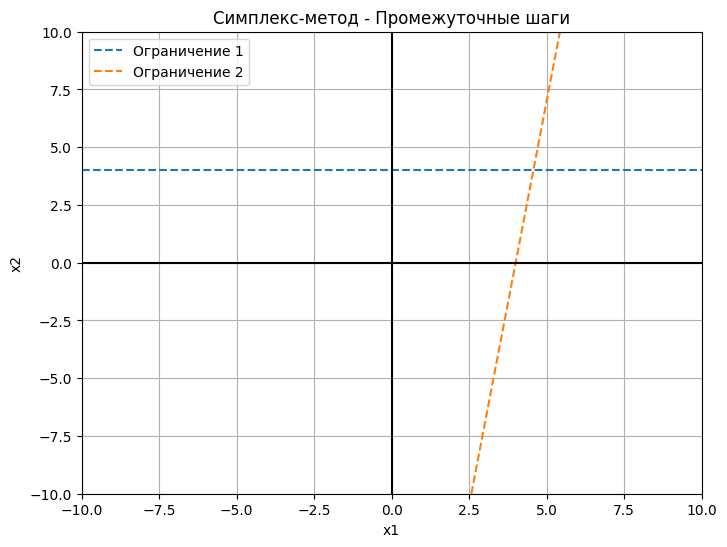

Разрешающий столбец: x2
Разрешающая строка: s1
Разрешающий элемент: 1.0
Обновленная симплекс-таблица:
     x1   x2   s1   s2     b
x2  0.0  1.0  1.0  0.0   4.0
s2  7.0  0.0  1.0  1.0  32.0
z   1.0  0.0  4.0  0.0  16.0




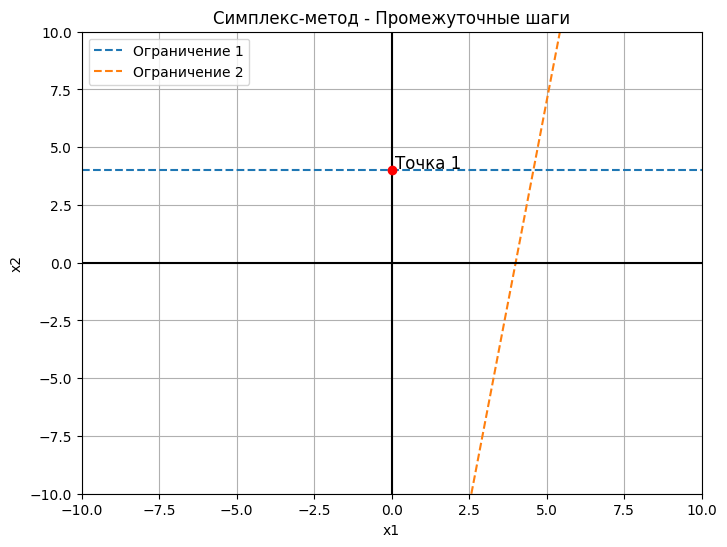

Достигнуто оптимальное решение.
Оптимальное решение: [0. 4.]
Оптимальное значение целевой функции: 16.0


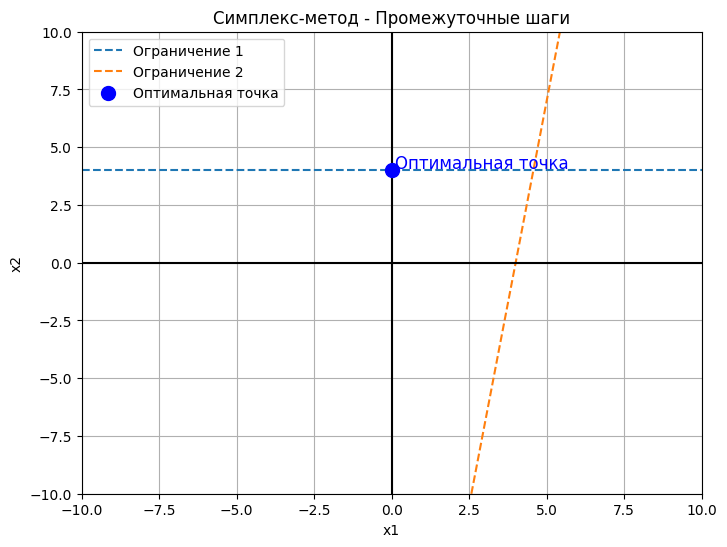

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simplex_method_max(c, A, b):
    """
    Реализация симплекс-метода для решения задачи линейного программирования.
    c: коэффициенты целевой функции (1D массив).
    A: матрица ограничений (2D массив).
    b: вектор ограничений (1D массив).
    """
    # Количество ограничений и переменных
    num_constraints, num_vars = A.shape

    # Формирование симплекс-таблицы
    tableau = np.hstack([A, np.eye(num_constraints), b.reshape(-1, 1)])
    c_row = np.hstack([-c, np.zeros(num_constraints + 1)])
    tableau = np.vstack([tableau, c_row])
    
    # Имена строк и столбцов для удобного отображения
    var_names = [f"x{i+1}" for i in range(num_vars)] + [f"s{i+1}" for i in range(num_constraints)] + ["b"]
    basis = [f"s{i+1}" for i in range(num_constraints)]

    def print_tableau():
        df = pd.DataFrame(tableau, columns=var_names, index=basis + ["z"])
        print(df)
        print("\n")

    def solve_for_y(coefficients):
        # Извлекаем коэффициенты a и b
        a, b = coefficients
        # Проверка на нулевой коэффициент при y
        if b == 0:
            raise ValueError("Нельзя выразить y, так как коэффициент при y равен нулю.")
        # Определяем выражение для y через x
        def y(x):
            return -a / b * x
        return y


    def visualize_simplex(points=None, optimal_point=None):
        # Задаём диапазон значений для визуализации
        func = solve_for_y(c)

        x1 = np.linspace(-10, 10, 400)
        y_func = func(x1)
        plt.figure(figsize=(8, 6))
        #plt.plot(x1, y_func, label="Функция ")

        # Построение ограничений
        for i in range(num_constraints):
            if A[i, 1] != 0:
                plt.plot(x1, (b[i] - A[i, 0] * x1) / A[i, 1], '--', label=f"Ограничение {i+1}")
            else:
                plt.axvline(x=b[i] / A[i, 0], label=f"Ограничение {i+1}")

        # Задаём оси координат
        plt.axhline(0, color='black', linewidth=1.5)
        plt.axvline(0, color='black', linewidth=1.5)

        # Отображение точек промежуточных решений
        if optimal_point:
            x_opt, y_opt = optimal_point
            plt.scatter(x_opt, y_opt, color='blue', s=100, zorder=10, label='Оптимальная точка')
            plt.text(x_opt + 0.1, y_opt + 0.1, "Оптимальная точка", fontsize=12, color='blue')
        else:
            if points:
                for i, (x, y) in enumerate(points):
                    plt.scatter(x, y, color='red', zorder=5)
                    plt.text(x + 0.1, y + 0.1, f"Точка {i+1}", fontsize=12)

        # Отображение оптимальной точки, если она передана
        

        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Симплекс-метод - Промежуточные шаги")
        plt.grid(True)
        plt.legend()
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.show()

    # Отображение начальной таблицы
    print("Начальная симплекс-таблица:")
    print_tableau()
    visualize_simplex()

    points = []  # Список для хранения точек промежуточных решений

    while True:
        # Проверка оптимальности
        if np.all(tableau[-1, :-1] >= 0):
            print("Достигнуто оптимальное решение.")
            break

        # Сортировка индексов по значениям в строке целевой функции (по убыванию)
        negative_indices = np.argsort(tableau[-1, :-1])
        
        # Поиск первого отрицательного элемента по очереди (чтобы не выбирать сразу наименьший)
        pivot_col = next((idx for idx in negative_indices if tableau[-1, idx] < 0), None)
        
        if pivot_col is None:
            print("Достигнуто оптимальное решение.")
            break

        print(f"Разрешающий столбец: {var_names[pivot_col]}")

        # Проверка на неограниченное решение
        if np.all(tableau[:-1, pivot_col] <= 0):
            print("Решение неограниченно.")
            return

        # Выбор разрешающей строки (наименьшее положительное отношение)
        ratios = tableau[:-1, -1] / tableau[:-1, pivot_col]
        pivot_row = np.where(ratios > 0, ratios, np.inf).argmin()
        print(f"Разрешающая строка: {basis[pivot_row]}")

        # Получение разрешающего элемента
        pivot_element = tableau[pivot_row, pivot_col]
        print(f"Разрешающий элемент: {pivot_element}")

        # Обновление таблицы
        tableau[pivot_row, :] /= pivot_element
        for i in range(len(tableau)):
            if i != pivot_row:
                tableau[i, :] -= tableau[i, pivot_col] * tableau[pivot_row, :]

        # Обновление базиса
        basis[pivot_row] = var_names[pivot_col]
        print("Обновленная симплекс-таблица:")
        print_tableau()

        # Получение текущего базисного решения
        solution = np.zeros(num_vars)
        for i, var in enumerate(basis):
            if var.startswith("x"):
                solution[int(var[1:]) - 1] = tableau[i, -1]
        
        # Сохранение текущей точки решения
        points.append((solution[0], solution[1]))
        
        # Визуализация текущей таблицы с точками
        visualize_simplex(points)

    # Оптимальное значение
    solution = np.zeros(num_vars)
    for i, var in enumerate(basis):
        if var.startswith("x"):
            solution[int(var[1:]) - 1] = tableau[i, -1]

    print(f"Оптимальное решение: {solution}")
    print(f"Оптимальное значение целевой функции: {tableau[-1, -1]}")

    # Визуализация оптимального решения на графике
    visualize_simplex(points, optimal_point=(solution[0], solution[1]))

# Пример задачи
c = np.array([-1, 4]) # -x + 4y | -a / b * x | y = x / 4 
A = np.array([[0, 1], 
              [7, -1]]) # y <= 4 и 7x - y <= 28 
b = np.array([4, 28]) 

simplex_method_max(c, A, b)

Начальная симплекс-таблица:
     x1   x2   s1   s2     b
s1  0.0  1.0  1.0  0.0   4.0
s2  7.0 -1.0  0.0  1.0  28.0
z   1.0 -4.0  0.0  0.0   0.0




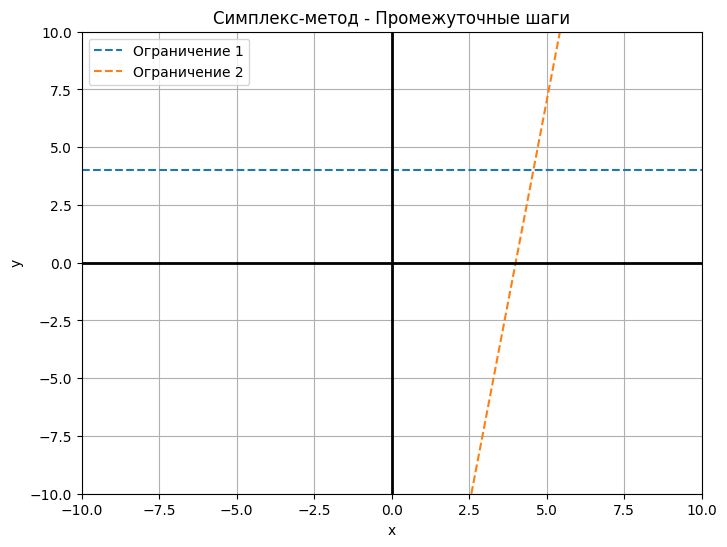

Разрешающий столбец: x1
Разрешающая строка: s2
Разрешающий элемент: 7.0
Обновленная симплекс-таблица:
     x1        x2   s1        s2    b
s1  0.0  1.000000  1.0  0.000000  4.0
x1  1.0 -0.142857  0.0  0.142857  4.0
z   0.0 -3.857143  0.0 -0.142857 -4.0




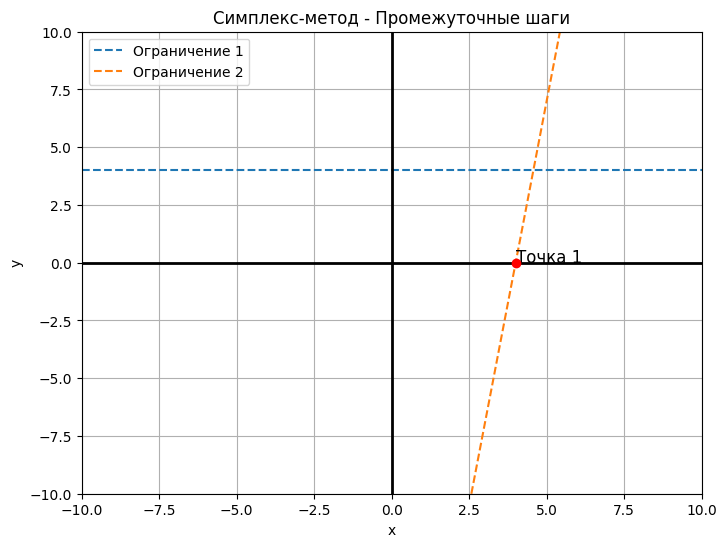

Достигнуто оптимальное решение.
---------------------------
Точка 1 - [(4.0, 0.0)]
Оптимальное решение: [4. 0.]
Оптимальное значение целевой функции: -4.0


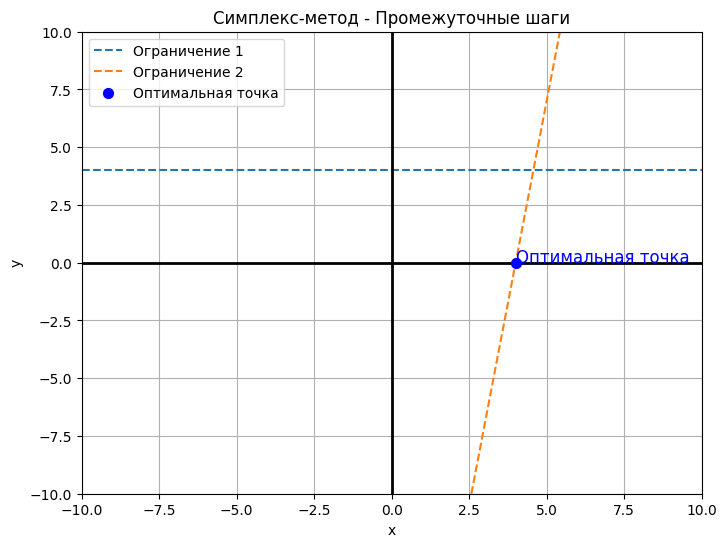

Финальная таблица с зависимыми и свободными переменными:
     x1        x2   s1        s2    b
s1  0.0  1.000000  1.0  0.000000  4.0
x1  1.0 -0.142857  0.0  0.142857  4.0
z   0.0 -3.857143  0.0 -0.142857 -4.0

Зависимые переменные: ['x1', 's1']
Свободные переменные: ['x2', 's2', 'b']


In [6]:
def simplex_method_min(c, A, b):
    """
    Реализация симплекс-метода для решения задачи линейного программирования.
    c: коэффициенты целевой функции (1D массив).
    A: матрица ограничений (2D массив).
    b: вектор ограничений (1D массив).
    """
    # Количество ограничений и переменных
    num_constraints, num_vars = A.shape


    """
    2. Введение дополнительных переменных
    Для каждого ограничения добавляются слак-переменные, чтобы превратить неравенства в равенства. Это происходит при создании симплекс-таблицы.
    """
    # Формирование симплекс-таблицы
    tableau = np.hstack([A, np.eye(num_constraints), b.reshape(-1, 1)])

    """
    3. Составление начальной симплекс-таблицы
    Симплекс-таблица формируется из коэффициентов целевой функции, коэффициентов ограничений, добавленных слак-переменных и вектора правых частей ограничений.
    """
    c_row = np.hstack([c, np.zeros(num_constraints + 1)])  # Знак не меняем, оставляем как есть
    tableau = np.vstack([tableau, c_row])
    

    """
    4. Определение начального базиса
    Определяются базисные переменные, которые равны значениям правых частей ограничений.
    """
    # Имена строк и столбцов для удобного отображения
    var_names = [f"x{i+1}" for i in range(num_vars)] + [f"s{i+1}" for i in range(num_constraints)] + ["b"]
    
    
    basis = [f"s{i+1}" for i in range(num_constraints)]

    def print_tableau():
        df = pd.DataFrame(tableau, columns=var_names, index=basis + ["z"])
        print(df)
        print("\n")

    def solve_for_y(coefficients):
        # Извлекаем коэффициенты a и b
        a, b = coefficients
        # Проверка на нулевой коэффициент при y
        if b == 0:
            raise ValueError("Нельзя выразить y, так как коэффициент при y равен нулю.")
        # Определяем выражение для y через x
        def y(x):
            return -a / b * x
        return y

    def visualize_simplex(points=None, optimal_point=None):
        # Задаём диапазон значений для визуализации
        x = np.linspace(-10, 10, 400)
        plt.figure(figsize=(8, 6))

        func = solve_for_y(c)
        y_func = func(x)
        #plt.plot(x, y_func, label="Функция ")

        # Построение ограничений
        for i in range(num_constraints):
            if A[i, 1] != 0:
                plt.plot(x, (b[i] - A[i, 0] * x) / A[i, 1], '--', label=f"Ограничение {i+1}")
            else:
                plt.axvline(x=b[i] / A[i, 0], label=f"Ограничение {i+1}")

        # Задаём оси координат
        plt.axhline(0, color='black', linewidth=2)
        plt.axvline(0, color='black', linewidth=2)

        # Отображение оптимальной точки, если она передана
        if optimal_point:
            x_opt, y_opt = optimal_point
            plt.scatter(x_opt, y_opt, color='blue', s=50, zorder=10, label='Оптимальная точка')
            plt.text(x_opt + 0.001, y_opt + 0.001, "Оптимальная точка", fontsize=12, color='blue')
        # Отображение точек промежуточных решений
        else:
            if points:
                for i, (x_val, y_val) in enumerate(points):
                    plt.scatter(x_val, y_val, color='red', zorder=5)
                    plt.text(x_val + 0.001, y_val + 0.001, f"Точка {i+1}", fontsize=12)

        

        plt.xlabel("x") 
        plt.ylabel("y")  
        plt.title("Симплекс-метод - Промежуточные шаги")
        plt.grid(True)
        plt.legend()
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.show()

    # Отображение начальной таблицы
    print("Начальная симплекс-таблица:")
    print_tableau()
    visualize_simplex()

    points = []  # Список для хранения точек промежуточных решений

    while True:
        """
        5. Проверка оптимальности
        В этом шаге проверяется, достигнуто ли оптимальное решение.
        """
        # Проверка оптимальности
        if np.all(tableau[-1, :-1] <= 0):  # Изменено для минимума
            print("Достигнуто оптимальное решение.")
            break
        """
        6. Выбор разрешающего столбца
        Определяется столбец с наибольшим отрицательным значением для выбора переменной, которую нужно ввести в базис.
        """
        
        # Сортировка индексов по значениям в строке целевой функции (по возрастанию)
        positive_indices = np.argsort(tableau[-1, :-1])
        
        # Поиск первого положительного элемента по очереди
        pivot_col = next((idx for idx in positive_indices if tableau[-1, idx] > 0), None)
        
        if pivot_col is None:
            print("Достигнуто оптимальное решение.")
            break

        print(f"Разрешающий столбец: {var_names[pivot_col]}")

        # Проверка на неограниченное решение
        if np.all(tableau[:-1, pivot_col] <= 0):
            print("Решение неограниченно.")
            return

        # Выбор разрешающей строки (наименьшее положительное отношение)
        # Мы добавляем условие, что если элемент в pivot_col равен 0, то его игнорируем
        with np.errstate(divide='ignore', invalid='ignore'):
            ratios = tableau[:-1, -1] / tableau[:-1, pivot_col]
            ratios[tableau[:-1, pivot_col] <= 0] = np.inf  # Устанавливаем бесконечность для нулей и отрицательных значений


        """
        7. Определение разрешающей строки
        Вычисляется отношение правой части к элементам разрешающего столбца, чтобы определить, какая переменная выйдет из базиса.
        """
        
        pivot_row = np.argmin(ratios)
        
        if np.isinf(ratios[pivot_row]):
            print("Не удалось найти разрешающую строку, решение не ограничено.")
            return

        print(f"Разрешающая строка: {basis[pivot_row]}")

        # Получение разрешающего элемента
        pivot_element = tableau[pivot_row, pivot_col]
        print(f"Разрешающий элемент: {pivot_element}")


        """
        8. Обновление симплекс-таблицы
        Симплекс-таблица обновляется после нахождения разрешающего элемента.
        """
        # Обновление таблицы
        tableau[pivot_row, :] /= pivot_element
        for i in range(len(tableau)):
            if i != pivot_row:
                tableau[i, :] -= tableau[i, pivot_col] * tableau[pivot_row, :]


        """
        9. Обновление базиса
        Базис обновляется, заменяя выходящую переменную на входящую.
        """
        # Обновление базиса
        basis[pivot_row] = var_names[pivot_col]
        print("Обновленная симплекс-таблица:")
        print_tableau()

        # Получение текущего базисного решения
        solution = np.zeros(num_vars)
        for i, var in enumerate(basis):
            if var.startswith("x"):
                solution[int(var[1:]) - 1] = tableau[i, -1]
        
        # Сохранение текущей точки решения
        points.append((solution[0], solution[1]))
        
        # Визуализация текущей таблицы с точками
        visualize_simplex(points)

    # Оптимальное значение
    solution = np.zeros(num_vars)
    for i, var in enumerate(basis):
        if var.startswith("x"):
            solution[int(var[1:]) - 1] = tableau[i, -1]

    print("---------------------------")
    print(f"Точка 1 - {points}")
    print(f"Оптимальное решение: {solution}")
    print(f"Оптимальное значение целевой функции: {tableau[-1, -1]}")

    # Визуализация оптимального решения на графике
    visualize_simplex(points, optimal_point=(solution[0], solution[1]))

    # Вывод финальной таблицы с зависимыми и свободными переменными
    print("Финальная таблица с зависимыми и свободными переменными:")
    final_df = pd.DataFrame(tableau, columns=var_names, index=basis + ["z"])
    print(final_df)

    # Определение зависимых и свободных переменных
    dependent_vars = [var for var in var_names if var in basis]
    free_vars = [var for var in var_names if var not in basis]

    print("\nЗависимые переменные:", dependent_vars)
    print("Свободные переменные:", free_vars)


"""
1. Приведение к стандартной форме
Для этого этапа нужно обеспечить, чтобы целевая функция была максимизируемой, ограничения — неравенствами вида 
 а переменные были неотрицательными. В коде это осуществляется на этапе инициализации входных данных.
"""
# Пример задачи
c = np.array([1, -4])  # Минимизируем x - 4y
A = np.array([[0, 1], 
              [7, -1]])  # y <= 4 и 7x - y <= 28
b = np.array([4, 28])

simplex_method_min(c, A, b)
